# Food Explorer
Produced using garden-level FAOstat datasets. 

So far the following datasets have been processed:

- [x] QCL
- [x] FBSC (FBS, FBSH)


We process both datasets in parallel, until the _Final Processing_ section, where we actually merge the datasets.

## 0. Parameters

In [1]:
dest_dir = "/tmp/food_explorer"

## 1. Imports & paths
Import the required libraries and define paths to load files (including data files and standardisation mappings for item and element names).

In [2]:
import json
from pathlib import Path

import pandas as pd
import numpy as np

from owid import catalog
from etl.paths import BASE_DIR, DATA_DIR

In [3]:
HERE = BASE_DIR / "etl/steps/data/garden/explorers/2021"

In [4]:
PATH_DATASET_QCL = DATA_DIR / "garden/faostat/2021-03-18/faostat_qcl"
PATH_DATASET_FBSC = DATA_DIR / "garden/faostat/2021-04-09/faostat_fbsc"
PATH_DATASET_POPULATION = DATA_DIR / "garden/owid/latest/key_indicators"
PATH_DATASET_POPULATION_GAPMINDER = (
    DATA_DIR / "meadow/open_numbers/latest/gapminder__systema_globalis"
)  # add

PATH_MAP_ITEM = HERE / "food_explorer.items.std.csv"
PATH_MAP_ELEM = HERE / "food_explorer.elements.std.csv"
PATH_REGIONS = HERE / "food_explorer.regions.json"
PATH_OUTLIERS = HERE / "food_explorer.outliers.json"

## 2. Load garden dataset
In this step we load the required datasets from Garden: QCL and FBSC.

In [5]:
qcl_garden = catalog.Dataset(PATH_DATASET_QCL)
fbsc_garden = catalog.Dataset(PATH_DATASET_FBSC)

We obtain table `bulk` from the dataset, which contains the data itself.

In [6]:
# Bulk data and items metadata
qcl_bulk = qcl_garden["bulk"]
fbsc_bulk = fbsc_garden["bulk"]

In the following step we discard column `Variable name`, which although useful for its clarity we don't actually need it in this process. Also, we reset the index as this will be needed in following operations. 

In [7]:
# QCL
qcl_bulk = qcl_bulk.reset_index()
qcl_bulk = qcl_bulk.drop(columns=["Variable Name"])
# FBSC
fbsc_bulk = fbsc_bulk.reset_index()
fbsc_bulk = fbsc_bulk.drop(columns=["Variable Name"])

Brief overview of the data.

In [8]:
# QCL
print(qcl_bulk.shape)
qcl_bulk.head()

(3009764, 6)


,Country,Item Code,Element Code,Year,Flag,Value
0,Armenia,221,5312,1992,M,<NA>
1,Armenia,221,5312,1993,M,<NA>
2,Armenia,221,5312,1994,M,<NA>
3,Armenia,221,5312,1995,M,<NA>
4,Armenia,221,5312,1996,M,<NA>


In [9]:
# FBSC
print(fbsc_bulk.shape)
fbsc_bulk.head()

(10373475, 6)


,Country,Item Code,Element Code,Year,Flag,Value
0,Armenia,2901,664,2014,Fc,3069.0
1,Armenia,2901,664,2015,Fc,3090.0
2,Armenia,2901,664,2016,Fc,3051.0
3,Armenia,2901,664,2017,Fc,3072.0
4,Armenia,2901,664,2018,Fc,2997.0


### Group some items
We know from Garden process to generate the FBSC dataset, that there are some items that "changed" its ID from one dataset to another:

- `2556 Groundnuts (Shelled Eq)` --> `2552 Groundnuts`
- `2805 Rice (Milled Equivalent)` --> `2807 Rice and products`

In [10]:
def group_item_codes(df, ids_old, ids_new, assign_to_old=False):
    # Check
    msk = df["Item Code"].isin(ids_old + ids_new)
    x = df[msk].groupby("Item Code").agg({"Year": ["min", "max"]})
    for id_old, id_new in zip(ids_old, ids_new):
        assert x.loc[id_new, ("Year", "min")] > x.loc[id_old, ("Year", "max")]
    # Replace
    if isinstance(assign_to_old, list):
        id_map = dict(
            (n, o) if f else (o, n) for o, n, f in zip(ids_old, ids_new, assign_to_old)
        )
    elif assign_to_old:
        id_map = dict(zip(ids_new, ids_old))
    else:
        id_map = dict(zip(ids_old, ids_new))
    print(id_map)
    df["Item Code"] = df["Item Code"].replace(id_map).astype(int)
    return df

In [11]:
fbsc_bulk = group_item_codes(
    fbsc_bulk, ids_old=[2556, 2805], ids_new=[2552, 2807], assign_to_old=[True, True]
)

{2552: 2556, 2807: 2805}


## 3. Select Flags
There are cases where we have more than just one entry for a `Country`, `Item Code`, `Element Code` and `Year`. This is due to the fact that there are multiple ways of reporting the data. All these different methodologies are identified by the field `Flag`, which tells us how a data point was obtained (see table below). This is given by FAOstat.

|Flag   |Description                                                                        |
|-------|-----------------------------------------------------------------------------------|
|`*`      |       Unofficial figure                                                           |
|`NaN`    | Official data                                                                     |
|`A`      |       Aggregate; may include official; semi-official; estimated or calculated data|
|`F`      |       FAO estimate                                                                |
|`Fc`     |      Calculated data                                                              |
|`Im`     |      FAO data based on imputation methodology                                     |
|`M`      |       Data not available                                                          |
|`S`      |       Standardised                                                                |
|`SD`     |       Statistical Discrepancy                                                     |
|`R`      |       Estimated data using trading partners database                              |


The following cell examines how many datapoints would be removed if we did _flag-prioritisation_. As per the output, we see that we would eliminate 30,688 rows (~1% of the data).

In [12]:
def check_flags_1(df):
    i_og = df.index.tolist()
    i_ne = df.drop_duplicates(
        subset=["Country", "Item Code", "Element Code", "Year"]
    ).index.tolist()
    print(
        f"Number of datapoints: {len(i_og)}\nNumber of datapoints (after dropping duplicates): {len(i_ne)}\nTotal datapoints removed: {len(i_og)-len(i_ne)}"
    )
    check_flags_2(df, i_og, i_ne)


def check_flags_2(df, i_og, i_ne):
    """Prints `[number of datapoints eliminated], True`"""
    df = df.set_index(["Country", "Item Code", "Element Code", "Year"])
    dups = df.index.duplicated()
    print(f"{dups.sum()}, {len(i_ne) == len(i_og)-dups.sum()}")
    # dups = qcl_bulk.index.duplicated(keep=False)
    df = df.reset_index()


check_flags_1(qcl_bulk)
print()
check_flags_1(fbsc_bulk)

Number of datapoints: 3009764
Number of datapoints (after dropping duplicates): 2979076
Total datapoints removed: 30688
30688, True

Number of datapoints: 10373475
Number of datapoints (after dropping duplicates): 10300082
Total datapoints removed: 73393
73393, True


### Flag prioritzation

In this step we define a Flag prioritisation rank, which allows us to discard duplicate entries based on which flag we "prefer". We do this by assigning a weight to each datapoint based on their `Flag` value (the higher, the more prioritised it is). On top of flag prioritisation, we always prefer non-`NaN` values regardless of their associated `Flag` value (we assign weight -1 to this datapoints). The weighting was shared and discussed with authors. 

The weight is added to the dataframe as a new column `Flag_priority`.

#### Example 1

    Country, Year, Product, Value, Flag 
    Afghanistan, 1993, Apple, 100, F
    Afghanistan, 1993, Apple, 120, A

We would choose first row, with flag F.

#### Example 2:

    Country, Year, Product, Value, Flag 
    Afghanistan, 1993, Apple, NaN, F
    Afghanistan, 1993, Apple, 120, A

We would choose second row, as first row is `NaN`.


In the following cell we filter rows based on `FLAG_PRIORITIES`.

In [13]:
# Create flag priority (add to df) More info at https://www.fao.org/faostat/en/#definitions
FLAG_PRIORITIES = {
    "M": 0,  # Data not available
    "SD": 10,  # Statistical Discrepancy
    "*": 20,  # Unofficial figure
    "R": 30,  # Estimated data using trading partners database
    "Fc": 40,  # Calculated data
    "S": 60,  # Standardized data
    "A": 70,  # Aggregate; may include official; semi-official; estimated or calculated data
    "Im": 80,  # FAO data based on imputation methodology
    "F": 90,  # FAO estimate
    np.nan: 100,  # Official data
}


def filter_by_flag_priority(df):
    # Add Flag priority column
    df.loc[:, "Flag_priority"] = df.Flag.replace(FLAG_PRIORITIES).tolist()
    df.loc[df.Value.isna(), "Flag_priority"] = -1
    # Remove duplicates based on Flag value
    df = df.sort_values("Flag_priority")
    df = df.drop_duplicates(
        subset=["Country", "Item Code", "Element Code", "Year"], keep="last"
    )
    return df.drop(columns=["Flag_priority", "Flag"])

In [14]:
# QCL
qcl_bulk = filter_by_flag_priority(qcl_bulk)
print(qcl_bulk.shape)

(2979076, 5)


In [15]:
# FBSC
fbsc_bulk = filter_by_flag_priority(fbsc_bulk)
print(fbsc_bulk.shape)

(10300082, 5)


## 4. Element Overview
This serves as an initial check on the meaning of `Element Code` values. In particular, we note that each `Element Code` value corresponds to a unique pair of _element name_  and _element unit_. Note, for instance, that _element_name_ "Production" can come in different flavours (i.e. units): "Production -- tones" and "Production -- 1000 No".

Based on the number of occurrences of each element code, we may want to keep only those that rank high.

**Note: This step uses file `PATH_MAP_ELEM`, which is a file that was generated using the code in a later cell.**

In [16]:
# Where do each element appear?
def get_stats_elements(df):
    res = df.reset_index().groupby("Element Code")["Item Code"].nunique()
    df_elem = pd.read_csv(PATH_MAP_ELEM, index_col="code")
    elem_map = (
        df_elem["name"] + " -- " + df_elem["unit"] + " -- " + df_elem.index.astype(str)
    )
    res = res.rename(index=elem_map.to_dict()).sort_values(ascending=False)
    return res

In [17]:
# QCL
get_stats_elements(qcl_bulk)

Element Code
Production -- tonnes -- 5510                          281
Area harvested -- ha -- 5312                          172
Yield -- hg/ha -- 5419                                171
Producing Animals/Slaughtered -- Head -- 5320          31
Yield/Carcass Weight -- hg/An -- 5417                  14
Stocks -- Head -- 5111                                 12
Yield -- hg/An -- 5420                                 10
Producing Animals/Slaughtered -- 1000 Head -- 5321      8
Yield/Carcass Weight -- 0.1g/An -- 5424                 8
Stocks -- 1000 Head -- 5112                             7
Laying -- 1000 Head -- 5313                             3
Yield -- 100mg/An -- 5410                               3
Yield -- hg -- 5422                                     2
Production -- 1000 No -- 5513                           2
Stocks -- No -- 5114                                    1
Name: Item Code, dtype: int64

In [18]:
# FBSC
get_stats_elements(fbsc_bulk)

Element Code
Protein supply quantity (g/capita/day) -- g/capita/day -- 674    121
Fat supply quantity (g/capita/day) -- g/capita/day -- 684        121
Food supply (kcal/capita/day) -- kcal/capita/day -- 664          121
Food supply quantity (kg/capita/yr) -- kg -- 645                 119
Food -- 1000 tonnes -- 5142                                      119
Domestic supply quantity -- 1000 tonnes -- 5301                  119
Other uses (non-food) -- 1000 tonnes -- 5154                     119
Export Quantity -- 1000 tonnes -- 5911                           119
Stock Variation -- 1000 tonnes -- 5072                           118
Production -- 1000 tonnes -- 5511                                118
Import Quantity -- 1000 tonnes -- 5611                           118
Residuals -- 1000 tonnes -- 5170                                 105
Tourist consumption -- 1000 tonnes -- 5171                       104
Losses -- 1000 tonnes -- 5123                                    101
Feed -- 1000 tonnes -

## 5. Reshape dataset
This step is simple and brief. It attempts to pivot the dataset in order to have three identifying columns (i.e. "keys") and several "value" columns based on the `Element Code` and `Value` columns.

This format is more Grapher/Explorer friendly, as it clearly divides the dataset columns into: Entities, Year, [Values].

In [19]:
def reshape_df(df):
    df = df.reset_index()
    df = df.pivot(
        index=["Country", "Item Code", "Year"], columns="Element Code", values="Value"
    )
    return df

In [20]:
# QCL
qcl_bulk = reshape_df(qcl_bulk)
# FBSC
fbsc_bulk = reshape_df(fbsc_bulk)

In [21]:
print("QCL:", qcl_bulk.shape)
print("FBSC:", fbsc_bulk.shape)

QCL: (1306070, 15)
FBSC: (1089063, 17)


## 6. Standardise Element and Item names (OPTIONAL)
In the following cells we obtain tables with the code, current name and number of occurrences of all the Items and Elements present in our dataset.

Based on this tables, Hannah (or another researcher), will revisit these and:
- Select those Items and Elements that we are interested in.
- Standardise naming proposals of Items and Elements.

Notes:
- We obtain the number of occurrences as this can assist the researcher in prioritising Items or Elements. 

### Elements
Here we obtain a table with the current namings for Elements (plus other variables). Note that we also propagate the unit names, as these may also be standardised (or even changed).

In [22]:
# Load table from dataset containing Element information
qcl_elem = qcl_garden["meta_qcl_element"]
fbsc_elem = fbsc_garden["meta_fbs_element"]

In [23]:
def get_elements_to_standardize(df, df_elem):
    # Obtain number of occurrences for each Element Code (each column is an element)
    elements = pd.DataFrame(df.notna().sum()).reset_index()
    elements = elements.sort_values(0, ascending=False)
    # Add names and unit info to the table
    elements = elements.merge(
        df_elem[["Element", "Unit", "Unit Description"]],
        left_on="Element Code",
        right_index=True,
    )
    # Rename column names
    elements = elements.rename(
        columns={
            "Element Code": "code",
            0: "number_occurrences",
            "Element": "name",
            "Unit": "unit",
            "Unit Description": "unit_description",
        }
    )[["code", "name", "unit", "unit_description", "number_occurrences"]]
    return elements

In [24]:
elements_qcl = get_elements_to_standardize(qcl_bulk, qcl_elem).assign(dataset="QCL")
elements_fbsc = get_elements_to_standardize(fbsc_bulk, fbsc_elem).assign(dataset="FBSC")

assert elements_qcl.merge(elements_fbsc, on="code").empty

Once the table is obtained, we take a look at it and export it. Note that we use a filename starting with `ign.`, as these are note git-tracked.

In [25]:
elements = pd.concat([elements_qcl, elements_fbsc])
elements.head()

,code,name,unit,unit_description,number_occurrences,dataset
13,5510,Production,tonnes,tonnes,1079145,QCL
3,5312,Area harvested,ha,hectares,588735,QCL
9,5419,Yield,hg/ha,hectograms per hectare,583687,QCL
5,5320,Producing Animals/Slaughtered,Head,head,156431,QCL
0,5111,Stocks,Head,head,90271,QCL


In [26]:
# elements.to_csv("ign.food.elements.csv", index=False)

### Items
Here we obtain a table with the current namings for Items (plus other variables).

In [27]:
# Load table from dataset containing Item information
qcl_item = qcl_garden["meta_qcl_item"]
fbsc_item = fbsc_garden["meta_item"]

As the following cell shows, this table comes with a multi-index, as codes may actually be referring to "Item Groups" or "Items".

In [28]:
qcl_item.head()

Item Group                      Item
Item Group Code Item Code                                             
QC              1714           Crops Primary             Crops Primary
                1753           Crops Primary       Fibre Crops Primary
                1730           Crops Primary          Oilcrops Primary
QA              1756            Live Animals              Live Animals
QL              1777       Livestock primary  Hides and skins, primary

Therefore, in the next cell we attempt to flatten code to name mappings.

To this end:
- We first create two separate dictionaries, mapping `Item Group Code --> Item Group` and `Item Code --> Item`, respectively.
- We note, however, that some codes appear both as "Items" and "Item Groups". This might be due to the fact that there are more than one level of items. That is, an Item can "belong" to an Item Group, which in turn belongs to yet a higher up Item Group. Therefore, we remove these codes from the item dictionary so they only appear in the item group dictionary.
- Next, we create a table with all items, their occurrences, whether they are Item Groups, and their FAO original namings.

In [29]:
def get_items_to_standardize(df, df_item):
    # Group
    map_item_g = dict(
        zip(
            df_item.index.get_level_values("Item Group Code").astype(str),
            df_item["Item Group"],
        )
    )
    # Item
    map_item = dict(
        zip(df_item.index.get_level_values("Item Code").astype(str), df_item["Item"])
    )

    # Correct
    map_item = {k: v for k, v in map_item.items() if k not in map_item_g}

    # Load item occurences
    items = (
        pd.DataFrame(df.reset_index()["Item Code"].value_counts())
        .reset_index()
        .astype(str)
        .rename(
            columns={
                "index": "code",
                "Item Code": "number_occurences",
            }
        )
    )
    # Add flag for groups
    items["type"] = (
        items["code"].isin(map_item_g).apply(lambda x: "Group" if x else None)
    )
    # Add name
    map_item_all = {**map_item, **map_item_g}
    items["name"] = items.code.replace(map_item_all)
    # Order columns
    items = items[["code", "name", "type", "number_occurences"]]
    return items

In [30]:
items_qcl = get_items_to_standardize(qcl_bulk, qcl_item).assign(dataset="QCL")
items_fbsc = get_items_to_standardize(fbsc_bulk, fbsc_item).assign(dataset="FBSC")
items = pd.concat([items_qcl, items_fbsc])

Once the table is obtained, we take a look at it and export it. Note that we use a filename starting with `ign.`, as these are note git-tracked.

In [31]:
items.head()

,code,name,type,number_occurences,dataset
0,1765,"Meat, Total",Group,11418,QCL
1,1738,Fruit Primary,Group,11272,QCL
2,1057,Chickens,None,11256,QCL
3,1808,"Meat, Poultry",Group,11246,QCL
4,1058,"Meat, chicken",None,11246,QCL


In [32]:
# items.to_csv("ign.food.items.csv", index=False)

## 7. Renaming Items and Elements
After the previous step, where we shared files `ign.food.items.csv` and `ign.food.elements.csv` with a researcher, they will review them and add the standardisation namings for all items and elements that we intend to use. Note that if no standardised name is provided, the item or element will be discarded.

Their proposals come in two files: `food_explorer.items.std.csv` and `food_explorer.elements.std.csv`. Note that we prefer working with the mapping `"item/element code" ---> "new standardised item/element name"`.

### Element

First of all, we load the standardisation table and remove NaN values (these belong to to-be-discarded elements).

In [33]:
# Get standardised values
df = pd.read_csv(PATH_MAP_ELEM, index_col="code")
df = df.dropna(subset=["name_standardised"])

If we display the content of the standardisation element file we observe that:
- Only some elements are preserved.
- There is the column `unit_name_standardised_with_conversion` and `unit_factor`, which provide the new unit and the factor to convert the old one into the new one. 
- Multiple codes are assigned to the same `name_standardised` and `unit_name_standardised_with_conversion`, which means that we will have to merge them. In particular, element "Yield" with unit "kg/animal" appears with four different codes!

In [34]:
# Show
df

,name,unit,unit_description,number_occurrences,Dataset,name_standardised,unit_name_standardised_with_conversion,unit_factor
code,,,,,,,,
5312,Area harvested,ha,hectares,539828,QCL,Area harvested,ha,1.0000
5301,Domestic supply quantity,1000 tonnes,thousand tonnes,1043347,FBSC,Domestic supply,tonnes,1000.0000
5911,Export Quantity,1000 tonnes,thousand tonnes,842139,FBSC,Exports,tonnes,1000.0000
684,Fat supply quantity (g/capita/day),g/capita/day,grams per capita per day,866317,FBSC,Food available for consumption,fat_g_per_day_per_capita,1.0000
5521,Feed,1000 tonnes,thousand tonnes,219816,FBSC,Feed,tonnes,1000.0000
5142,Food,1000 tonnes,thousand tonnes,966295,FBSC,Food,tonnes,1000.0000
664,Food supply (kcal/capita/day),kcal/capita/day,kilocalorie per capita per day,1005702,FBSC,Food available for consumption,kcal_per_day_per_capita,1.0000
645,Food supply quantity (kg/capita/yr),kg,kilograms,966185,FBSC,Food available for consumption,kg_per_capita_per_year,1.0000
5611,Import Quantity,1000 tonnes,thousand tonnes,1008063,FBSC,Imports,tonnes,1000.0000


We keep columns in data file that belong to the "elements of interest" (those with renaming).

In [35]:
# Filter elements of interest
qcl_bulk = qcl_bulk[[col for col in df.index if col in qcl_bulk.columns]]
fbsc_bulk = fbsc_bulk[[col for col in df.index if col in fbsc_bulk.columns]]

We modify the values of some elements, based on the new units and `unit_factor` values.

In [36]:
# Factor
qcl_bulk = qcl_bulk.multiply(df.loc[qcl_bulk.columns, "unit_factor"])
fbsc_bulk = fbsc_bulk.multiply(df.loc[fbsc_bulk.columns, "unit_factor"])

Next, we merge codes into single codes:
- **Yield**: `5417, 5420, 5424, 5410 ---> 5417` (QCL)
- **Animals slaughtered**: `5320, 5321 ---> 5320` (QCL)

As previously highlighted, all of them are mapped to the same (name, unit) tupple.

In [37]:
# QCL
item_code_merge = {
    5417: [5420, 5424, 5410],
    5320: [5321],
}
items_drop = [ii for i in item_code_merge.values() for ii in i]
for code_new, codes_old in item_code_merge.items():
    for code_old in codes_old:
        qcl_bulk[code_new] = qcl_bulk[code_new].fillna(qcl_bulk[code_old])
qcl_bulk = qcl_bulk.drop(columns=items_drop)

Finally, we rename the column names (so far element codes) to more prosaic element identifiers (`[element-name]__[unit]`).

In [38]:
# Build element name
a = df["name_standardised"].apply(lambda x: x.lower().replace(" ", "_")).astype(str)
b = (
    df["unit_name_standardised_with_conversion"]
    .apply(lambda x: x.lower().replace(" ", "_"))
    .astype(str)
)
df["element_name"] = (a + "__" + b).tolist()
# Obtain dict Element Code -> element name
map_elem = df["element_name"].to_dict()

In [39]:
# Change columns names
qcl_bulk = qcl_bulk.rename(columns=map_elem)
fbsc_bulk = fbsc_bulk.rename(columns=map_elem)

In [40]:
# Show dataframe with standardised element names
qcl_bulk.head()

Element Code                area_harvested__ha  \
Country     Item Code Year                       
Afghanistan 15        1961           2230000.0   
                      1962           2341000.0   
                      1963           2341000.0   
                      1964           2345000.0   
                      1965           2347000.0   

Element Code                producing_or_slaughtered_animals__animals  \
Country     Item Code Year                                              
Afghanistan 15        1961                                       <NA>   
                      1962                                       <NA>   
                      1963                                       <NA>   
                      1964                                       <NA>   
                      1965                                       <NA>   

Element Code                production__tonnes  yield__tonnes_per_ha  \
Country     Item Code Year                                             
Afghanistan 15        1961           2279000.0                 1.022   
                      1962           2279000.0                0.9735   
                      1963           1947000.0                0.8317   
                      1964           2230000.0                 0.951   
                      1965           2282000.0                0.9723   

Element Code                yield__kg_per_animal  
Country     Item Code Year                        
Afghanistan 15        1961                  <NA>  
                      1962                  <NA>  
                      1963                  <NA>  
                      1964                  <NA>  
                      1965                  <NA>

### Item
We now load the standardisation item table and remove `NaN` values (these belong to to-be-discarded items).

In [41]:
# Get standardised values
df = pd.read_csv(PATH_MAP_ITEM, index_col="code")
map_item_std = df.dropna(subset=["name_standardised"])["name_standardised"].to_dict()

Briefly display first 10 mappings.

In [42]:
{k: v for (k, v) in list(map_item_std.items())[:10]}

{221: 'Almonds',
 711: 'Herbs (e.g. fennel)',
 515: 'Apples',
 2617: 'Apples',
 526: 'Apricots',
 226: 'Areca nuts',
 366: 'Artichokes',
 367: 'Asparagus',
 1107: 'Asses',
 572: 'Avocados'}

Next, we do a simple check of item name uniqueness. Note that we can have multiple codes assigned to the same `name_standardised`, as part of the standardisation process, BUT these should be in different datasets so we don't have any element conflicts.

In [43]:
# Show "fused" products from QCL and FBSC
x = pd.DataFrame.from_dict(map_item_std, orient="index", columns=["name"]).reset_index()
x = x.groupby("name").index.unique().apply(list)
x = x[x.apply(len) > 1]
print("There are", len(x), "fused products:\n", x)

There are 53 fused products:
 name
Apples                   [515, 2617]
Bananas                  [486, 2615]
Barley                    [44, 2513]
Beans, dry               [2546, 176]
Cassava                  [125, 2532]
Chillies and peppers     [689, 2641]
Coconut oil              [2578, 252]
Cottonseed               [329, 2559]
Cottonseed oil           [2575, 331]
Dates                    [577, 2619]
Eggs                    [2949, 1783]
Fruit                   [1738, 2919]
Grapefruit               [507, 2613]
Groundnut oil            [2572, 244]
Groundnuts               [2556, 242]
Honey                   [2745, 1182]
Lemons and limes         [497, 2612]
Maize                     [56, 2514]
Maize oil                 [2582, 60]
Meat, Total             [2943, 1765]
Meat, poultry           [1808, 2734]
Meat, sheep and goat    [2732, 1807]
Milk                    [2948, 1780]
Millet                    [79, 2517]
Oilcrops                [1731, 2913]
Olive oil                [261, 2580]
Oli

In [44]:
# Check `code` --> `name_standardised` is unique in each dataset
assert (
    df.dropna(subset=["name_standardised"])
    .reset_index()
    .groupby(["dataset", "name_standardised"])
    .code.nunique()
    .max()
    == 1
)

Next, we filter out items that we are not interested in and add a new column (`Product`) with the standardised item names.

In [45]:
def standardise_product_names(df):
    df = df.reset_index()
    df = df[df["Item Code"].isin(map_item_std)]
    df.loc[:, "Product"] = df["Item Code"].replace(map_item_std).tolist()
    df = df.drop(columns=["Item Code"])
    # Set back index
    df = df.set_index(["Product", "Country", "Year"])
    return df

In [46]:
qcl_bulk = standardise_product_names(qcl_bulk)
fbsc_bulk = standardise_product_names(fbsc_bulk)

## 8. Dataset merge
Here we add the final processing steps:
- Merge datasets `QCL` + `FBSC`
- Discard products (former items) that do not contain any value for the "elements of interest".

In [47]:
# Merge datasets
fe_bulk = pd.merge(qcl_bulk, fbsc_bulk, how="outer", left_index=True, right_index=True)

In [48]:
print("QCL // shape:", qcl_bulk.shape, "/ not-NaN:", qcl_bulk.notna().sum().sum())
print("FBSC // shape:", fbsc_bulk.shape, "/ not-NaN:", fbsc_bulk.notna().sum().sum())
print("FE // shape:", fe_bulk.shape, "/ not-NaN:", fe_bulk.notna().sum().sum())

QCL // shape: (1027372, 5) / not-NaN: 2115132
FBSC // shape: (573533, 11) / not-NaN: 4463526
FE // shape: (1309818, 16) / not-NaN: 6578658


In [49]:
# Drop nulls (some products dont have any value for the elements of interest)
fe_bulk = fe_bulk.dropna(how="all")
print("FE (after NaN-drop):", fe_bulk.shape)

FE (after NaN-drop): (1125488, 16)


In [50]:
print(fe_bulk.shape)
fe_bulk.head()

(1125488, 16)


Element Code              area_harvested__ha  \
Product Country     Year                       
Almonds Afghanistan 1975                 0.0   
                    1976              5900.0   
                    1977              6000.0   
                    1978              6000.0   
                    1979              6000.0   

Element Code              producing_or_slaughtered_animals__animals  \
Product Country     Year                                              
Almonds Afghanistan 1975                                       <NA>   
                    1976                                       <NA>   
                    1977                                       <NA>   
                    1978                                       <NA>   
                    1979                                       <NA>   

Element Code              production__tonnes  yield__tonnes_per_ha  \
Product Country     Year                                             
Almonds Afghanistan 1975                 0.0                  <NA>   
                    1976              9800.0                 1.661   
                    1977              9000.0                   1.5   
                    1978             12000.0                   2.0   
                    1979             10500.0                  1.75   

Element Code              yield__kg_per_animal  domestic_supply__tonnes  \
Product Country     Year                                                  
Almonds Afghanistan 1975                  <NA>                      NaN   
                    1976                  <NA>                      NaN   
                    1977                  <NA>                      NaN   
                    1978                  <NA>                      NaN   
                    1979                  <NA>                      NaN   

Element Code              exports__tonnes  \
Product Country     Year                    
Almonds Afghanistan 1975              NaN   
                    1976              NaN   
                    1977              NaN   
                    1978              NaN   
                    1979              NaN   

Element Code              food_available_for_consumption__fat_g_per_day_per_capita  \
Product Country     Year                                                             
Almonds Afghanistan 1975                                                NaN          
                    1976                                                NaN          
                    1977                                                NaN          
                    1978                                                NaN          
                    1979                                                NaN          

Element Code              feed__tonnes  food__tonnes  \
Product Country     Year                               
Almonds Afghanistan 1975           NaN           NaN   
                    1976           NaN           NaN   
                    1977           NaN           NaN   
                    1978           NaN           NaN   
                    1979           NaN           NaN   

Element Code              food_available_for_consumption__kcal_per_day_per_capita  \
Product Country     Year                                                            
Almonds Afghanistan 1975                                                NaN         
                    1976                                                NaN         
                    1977                                                NaN         
                    1978                                                NaN         
                    1979                                                NaN         

Element Code              food_available_for_consumption__kg_per_capita_per_year  \
Product Country     Year                                                           
Almonds Afghanistan 1975                                                

## 9. Post processing
In this section we obtain the metrics for all regions and add per-capita counterparts. So far, we include income groups by the World Bank, continents as defined by OWID and World. The values for these entities are obtained using only data present in the dataset (i.e. some countries may be missing).


- Normalize metrics
    - Add population column
    - Weight columns
    - Rename columns
- Obtain metrics for regions
- Add population column, including regions

In [51]:
fe_bulk = fe_bulk.reset_index()

### 9.0 Build population table

In [68]:
# Load population dataset
indicators = catalog.Dataset(PATH_DATASET_POPULATION)
population = indicators["population"][["population"]].reset_index()

In [69]:
# Load from gapminder (former countries)
# more info: https://github.com/open-numbers/ddf--gapminder--systema_globalis/blob/master/ddf--entities--geo--country.csv
gapminder = catalog.Dataset(PATH_DATASET_POPULATION_GAPMINDER)
population_gap = (
    gapminder["total_population_with_projections"]
    .reset_index()
    .rename(columns={"time": "year", "total_population_with_projections": "population"})
)

gapminder_country_codes = {
    "ussr": "USSR",
    "cheslo": "Czechoslovakia",
    "yug": "Yugoslavia",
    "eri_a_eth": "Eritrea and Ethiopia",
    "scg": "Serbia and Montenegro",
}
former_states = list(gapminder_country_codes.values())

population_gap = population_gap[population_gap.geo.isin(gapminder_country_codes)]
population_gap = population_gap.assign(
    country=population_gap.geo.map(gapminder_country_codes)
).drop(columns=["geo"])

# Filter years (former states only for past interval, not overlapping with current countries)
date_window = (
    fe_bulk[fe_bulk.Country.isin(former_states)]
    .groupby("Country")
    .Year.agg(["min", "max"])
    .to_dict(orient="index")
)
population_ = []
for state, dates in date_window.items():
    df_ = population_gap[
        (population_gap.country == state)
        & (population_gap.year >= dates["min"])
        & (population_gap.year <= dates["max"])
    ]
    population_.append(df_)
population_gap = pd.concat(population_, ignore_index=True)

# Index
population_gap = population_gap.set_index(["country", "year"], verify_integrity=True)

In [70]:
date_window

{'Czechoslovakia': {'min': 1961, 'max': 1992},
 'Eritrea and Ethiopia': {'min': 1961, 'max': 1992},
 'Serbia and Montenegro': {'min': 1992, 'max': 2005},
 'USSR': {'min': 1961, 'max': 1991},
 'Yugoslavia': {'min': 1961, 'max': 1991}}

In [82]:
# Ensure no overlapping
former_to_current = {
    "USSR": [
        "Lithuania",
        "Georgia",
        "Estonia",
        "Latvia",
        "Ukraine",
        "Moldova",
        "Kyrgyzstan",
        "Uzbekistan",
        "Tajikistan",
        "Armenia",
        "Azerbaijan",
        "Turkmenistan",
        "Belarus",
        "Russia",
        "Kazakhstan",
    ],
    "Yugoslavia": [
        "Croatia",
        "Slovenia",
        "North Macedonia",
        "Bosnia and Herzegovina",
        "Serbia",
        "Montenegro",
    ],
    "Czechoslovakia": ["Czechia", "Slovakia"],
    "Eritrea and Ethiopia": ["Ethiopia", "Eritrea"],
    "Serbia and Montenegro": ["Serbia", "Montenegro"],
    "Sudan (former)": ["Sudan", "South Sudan"],
}
former_states = list(former_to_current.keys())

for former, current in former_to_current.items():
    msk = fe_bulk.Country.isin(current)
    current_start = fe_bulk.loc[msk, "Year"].min()
    former_end = fe_bulk.loc[fe_bulk.Country == former, "Year"].max()
    assert former_end < current_start

In [72]:
# Estimate Sudan (former)
msk = population.country.isin(["South Sudan", "Sudan"]) & (population.year < 2012)
pop_sudan = (
    population[msk]
    .groupby("year", as_index=False)
    .population.sum()
    .assign(country="Sudan (former)")
)
population = pd.concat([pop_sudan, population], ignore_index=True)
date_window = date_window | {"Sudan (former)": {"min": 1961, "max": 2011}}

In [73]:
# Filter current states that did not exist
msk = None
for former, current in former_to_current.items():
    if msk is None:
        msk = population.country.isin(former_to_current[former]) & (
            population.year <= date_window[former]["max"]
        )
    else:
        msk |= population.country.isin(former_to_current[former]) & (
            population.year <= date_window[former]["max"]
        )
population = population[
    (population.year >= fe_bulk.Year.min()) & (population.year <= fe_bulk.Year.max())
].astype({"year": int})
population = population.loc[~msk]
population = population.set_index(["country", "year"], verify_integrity=True)

In [74]:
# Merge
population = pd.concat([population, population_gap])

### 9.1 Normalize metrics
In this section, we undo the _per_capita_ part of some metrics. We do this so we can aggregate countries into regions and later normalize by the total population.

#### Add population column

In [75]:
countries_pop = set(population.index.levels[0])
countries = set(fe_bulk.Country)
print(
    f"Missing {len(countries_missing := countries.difference(countries_pop))} countries: {countries_missing}"
)
if len(countries_missing) > 17:
    raise ValueError("More countries missing than expected!")

Missing 12 countries: {'Bermuda', 'Polynesia', 'Niue', 'Tokelau', 'Oceania', 'French Polynesia', 'Africa', 'Cook Islands', 'Asia', 'Europe', 'Macao', 'Melanesia'}


In [76]:
shape_first = fe_bulk.shape[0]
fe_bulk = fe_bulk.merge(
    population, left_on=["Country", "Year"], right_on=["country", "year"]
)
print(f"Decrease of {round(100*(1-fe_bulk.shape[0]/shape_first))}% rows")

Decrease of 7% rows


#### Weight columns

In [77]:
# Define which columns will be weighted
keyword = "_per_capita"
columns_per_capita = {
    col: col.replace(keyword, "") for col in fe_bulk.columns if keyword in col
}
# Normalize and rename columns
fe_bulk[list(columns_per_capita)] = fe_bulk[list(columns_per_capita)].multiply(
    fe_bulk["population"], axis=0
)
fe_bulk = fe_bulk.rename(columns=columns_per_capita).drop(columns=["population"])

### 9.2 Add regions
Here we obtain the metrics for each region (continents, income groups and World). We avoid computing the aggregates for metrics relative to land use and animal use, as for these we would need the number of land and animals used per country. We can estimate `yield__tonnes_per_ha`, with other available metrics but will leave `yield__kg_per_animal` as NaN for all regions.

#### Create mappings Country ---> Region

In [78]:
# Load region map
with open(PATH_REGIONS, "r") as f:
    regions = json.load(f)
regions_all = ["World"] + list(regions)

income = [
    "High-income countries",
    "Low-income countries",
    "Lower-middle-income countries",
    "Upper-middle-income countries",
]
continents = [
    "Antarctica",
    "Africa",
    "Asia",
    "Europe",
    "South America",
    "North America",
    "Oceania",
]
country2continent = {vv: k for k, v in regions.items() for vv in v if k in continents}
country2income = {vv: k for k, v in regions.items() for vv in v if k in income}

In [86]:
# Ensure former states presence
country2continent["Sudan (former)"] = "Africa"
country2income = {
    **country2income,
    "Czechoslovakia": "High-income countries",
    "Eritrea and Ethiopia": "Low-income countries",
    "Serbia and Montenegro": "Upper-middle-income countries",
    "Yugoslavia": "Upper-middle-income countries",
    "USSR": "Upper-middle-income countries",
    "Sudan (former)": "Low-income countries",
}
for state in former_states:
    assert state in country2continent

#### Remove default regions (if any)

In [87]:
fe_bulk = fe_bulk.loc[~fe_bulk.Country.isin(regions_all)].reset_index(drop=True)

#### Function and variables to get metrics for regions
Definition of functions recurrently needed and some variables

In [88]:
def get_df_regions(df, mapping, column_location, columns_index, columns_aggregate=None):
    # Continents
    df_regions = df.assign(**{column_location: df[column_location].replace(mapping)})
    if columns_aggregate is not None:
        df_regions = df_regions.groupby(columns_index, as_index=False)[
            columns_aggregate
        ].sum(min_count=1)
    else:
        df_regions = df_regions.groupby(columns_index, as_index=False).sum(min_count=1)
    # Only keep new regions
    msk = df_regions[column_location].isin(set(mapping.values()))
    df_regions = df_regions.loc[msk]
    print(f"{round(100*df_regions.shape[0]/df.shape[0], 2)}% increase in rows")
    return df_regions

In [89]:
columns_index = ["Product", "Country", "Year"]
columns_exclude = columns_index + ["yield__tonnes_per_ha", "yield__kg_per_animal"]
columns_aggregate = [col for col in fe_bulk.columns if col not in columns_exclude]

#### Estimate region data

In [90]:
# World
fe_bulk_world = (
    fe_bulk.groupby(["Product", "Year"], as_index=False)[columns_aggregate]
    .sum(min_count=1)
    .assign(Country="World")
)
print(f"{round(100*fe_bulk_world.shape[0]/fe_bulk.shape[0], 2)}% increase in rows")
# Continents
fe_bulk_continent = get_df_regions(
    fe_bulk, country2continent, "Country", columns_index, columns_aggregate
)
# Income groups
fe_bulk_income = get_df_regions(
    fe_bulk, country2income, "Country", columns_index, columns_aggregate
)

1.04% increase in rows
5.66% increase in rows
3.94% increase in rows


#### Merge

In [91]:
# Concatenate
fe_bulk = pd.concat([fe_bulk, fe_bulk_world, fe_bulk_continent, fe_bulk_income])

#### Add missing metrics for regions

In [92]:
msk = (
    (fe_bulk.Country.isin(regions_all))
    & (fe_bulk["area_harvested__ha"] != 0)
    & (~fe_bulk["area_harvested__ha"].isna())
)
fe_bulk.loc[msk, "yield__tonnes_per_ha"] = (
    fe_bulk.loc[msk, "production__tonnes"] / fe_bulk.loc[msk, "area_harvested__ha"]
)

### 9.3 Population
Next, we will add a column with the population of each country (or region). Note that some regions are not present in the population dataset, hence we first need to add these.

In [93]:
# Load population dataset
population = population.reset_index()

#### Obtain continent and income group populations

In [94]:
population_continent = get_df_regions(
    population, country2continent, "country", ["country", "year"]
)
population_income = get_df_regions(
    population, country2income, "country", ["country", "year"]
)

3.11% increase in rows
2.07% increase in rows


In [95]:
# Concatenate
population = pd.concat([population, population_continent, population_income])
population = population.set_index(["country", "year"])

#### Add `population` column

In [96]:
fe_bulk = fe_bulk.merge(population, left_on=["Country", "Year"], right_index=True)

### 9.4 Remove former countries
We want the values reported for former states to account for regions (continents, income groups), but not that they appear on themselves on the explorer. Therefore, we eliminate these from the final dataset.

In [103]:
fe_bulk = fe_bulk[~fe_bulk.Country.isin(former_states)]

#### Set index

In [104]:
fe_bulk = fe_bulk.set_index(
    ["Product", "Country", "Year"], verify_integrity=True
).sort_index()

### 9.5 Value checks

#### Remove values for _food_available_for_consumption__kcal_per_day
We remove values for metric `food_available_for_consumption__kcal_per_day` whenever they seem wrong. Our criteria is to find out if for a given `(item,country)` this metric only has few values. We define _few_ as below a pre-defined threshold `th`.

Note, here removing means assigning `NaN` to this metric for the rows considered.

In [105]:
# Overview of the distribution of different metric values
res = fe_bulk.groupby(
    [fe_bulk.index.get_level_values(0), fe_bulk.index.get_level_values(1)]
).food_available_for_consumption__kcal_per_day.nunique()
res[res != 0].value_counts(normalize=True).cumsum().head(10)

58    0.486072
1     0.619855
27    0.676723
2     0.697060
26    0.713928
19    0.727518
13    0.740434
5     0.751904
3     0.762988
7     0.772819
Name: food_available_for_consumption__kcal_per_day, dtype: float64

In [106]:
# Get valid (item,country)
threshold = 5
idx_keep = res[res < threshold].index
# Assign NaNs
index_2 = pd.Index([i[:2] for i in fe_bulk.index])
msk = index_2.isin(idx_keep)
fe_bulk.loc[msk, "food_available_for_consumption__kcal_per_day"] = pd.NA

#### Remove outliers
Remove outliers (i.e. subsitute the values with `NaN`).

In [107]:
# Define for each column (metric) which indices should be 'removed'
with open(PATH_OUTLIERS, "r") as f:
    outliers = json.load(f)

In [108]:
for datapoints in outliers:
    fe_bulk.loc[datapoints["index"], datapoints["column"]] = pd.NA

#### Remove all-zero timeseries
Here we detect all `(country, product, metric)` which timeseries is all zeroes and set it to `NaN`. This way, this metric will be ignored in Grapher for the given Country and product.

In [109]:
# Unpivot
x = fe_bulk.melt(var_name="metric", ignore_index=False).reset_index()

In [110]:
# Find (product, country, metric) with all zeros (or NaNs)
res = x.groupby(["Product", "Country", "metric"]).agg(
    value_sum=("value", "sum"), value_nunique=("value", "nunique")
)
msk = (
    (res["value_nunique"] == 1)
    & (res["value_sum"] == 0)
    & (res.index.get_level_values(2) != "population")
)
idx = msk[msk == True].index

In [111]:
# Replace with NaNs
xx = x.set_index(["Product", "Country", "metric"])
xx.loc[idx, "value"] = np.nan
xx = xx.reset_index()

In [112]:
# Pivot back
fe_bulk = xx.pivot(["Product", "Country", "Year"], "metric", "value").astype(
    fe_bulk.dtypes
)

## 10. Export
Time to export the shining brand new dataset!

We export it in two flavours: bulk and file-per-product formats. The former is the standard format, while the later is intended to power OWID tools such as explorers.

### Define metadata
Prior to export, we need to create the metadata content for this dataset. It basically propagates the metadata from its building pieces (QCL so far).

For this dataset, we use namespace `explorers`, which is intended for datasets aimed at powering explorers (this may change).

In [113]:
from owid.catalog.meta import DatasetMeta

In [114]:
# Initialize dataset
fe_garden = catalog.Dataset.create_empty(dest_dir)
fe_garden.metadata = DatasetMeta(
    namespace="explorers",
    short_name="food_explorer",
    title="Food Explorer: Livestock & Crops, Food Balances - FAO (2017, 2021)",
    description=(
        "This dataset has been created by Our World in Data, merging existing FAOstat datsets. In particular, we have used 'Crops and livestock products' (QCL) and 'Food Balances' (FBSH and FBS) datasets. Each row contains all the "
        "metrics for a specific combination of (Country, Product, Year). The metrics may come from different datasets."
    ),
    sources=qcl_garden.metadata.sources + fbsc_garden.metadata.sources,
    licenses=qcl_garden.metadata.licenses + fbsc_garden.metadata.licenses,
)
fe_garden.save()

### In bulk

Preserve the bulk file for QA or manual analysis.

#### Create metadata for fields
Here we create the content for `field` metadata field, which contains metric-specific information.

In [115]:
# Load table from dataset containing Element information
qcl_elem = qcl_garden["meta_qcl_element"]
fbsc_elem = fbsc_garden["meta_fbs_element"]
qcl_elem["name_std"] = qcl_elem.index.map(map_elem)
fbsc_elem["name_std"] = fbsc_elem.index.map(map_elem)
element_metadata = pd.concat(
    [qcl_elem.dropna().assign(dataset="QCL"), fbsc_elem.dropna().assign(dataset="FBS")]
)
# Final patch
patch = {
    "food_available_for_consumption__fat_g_per_day_per_capita": "food_available_for_consumption__fat_g_per_day",
    "food_available_for_consumption__protein_g_per_day_per_capita": "food_available_for_consumption__protein_g_per_day",
    "food_available_for_consumption__kcal_per_day_per_capita": "food_available_for_consumption__kcal_per_day",
    "food_available_for_consumption__kg_per_capita_per_year": "food_available_for_consumption__kg_per_year",
}
element_metadata["name_std"] = element_metadata["name_std"].replace(patch)

In [116]:
from operator import itemgetter

In [117]:
# Fill 'easy' fields
def _get_source_ids(dataset_code):
    res = [
        i
        for i, source in enumerate(fe_garden.metadata.sources)
        if f"{dataset_code}" in source.owid_data_url
    ]
    return res


def _build_description_extra(fe_bulk, col):
    num_products = len(set(fe_bulk[col].dropna().index.get_level_values(0)))
    num_countries = len(set(fe_bulk[col].dropna().index.get_level_values(1)))
    description = f"This metric is present in {num_products} products and {num_countries} countries."
    return description


def _get_sources_and_licenses(dataset_code):
    source_ids = _get_source_ids(dataset_code)
    sources = [fe_garden.metadata.sources[i] for i in source_ids]
    licenses = [fe_garden.metadata.licenses[i] for i in source_ids]
    return {"sources": sources, "licenses": licenses}


fields = {}
columns = list(fe_bulk.columns) + fe_bulk.index.names
for col in columns:
    msk = element_metadata.name_std == col
    if msk.sum() == 0:
        msk = element_metadata.name_std == f"{col}_per_capita"

    if msk.sum() == 1:
        dataset_code = element_metadata.loc[msk, "dataset"].item()
        description = element_metadata.loc[msk, "Description"].item()
        fields[col] = catalog.VariableMeta(
            title="",
            description=description,
            **_get_sources_and_licenses(dataset_code),
            display={"description_extra": _build_description_extra(fe_bulk, col)},
        )
    elif msk.sum() > 1:
        dataset_codes = element_metadata.loc[msk, "dataset"]
        if dataset_codes.nunique() != 1:
            raise ValueError(
                f"Merged metrics should all be from the same dataset! Check {col}"
            )
        dataset_code = dataset_codes.unique()[0]
        fields[col] = catalog.VariableMeta(
            title="",
            description="",
            **_get_sources_and_licenses(dataset_code),
            display={"description_extra": _build_description_extra(fe_bulk, col)},
        )
    else:
        fields[col] = catalog.VariableMeta()

In [118]:
# Check missing fields
cols_missing = [f for f, v in fields.items() if v.description == ""]
assert cols_missing == [
    "exports__tonnes",
    "food_available_for_consumption__fat_g_per_day",
    "food_available_for_consumption__kcal_per_day",
    "food_available_for_consumption__kg_per_year",
    "food_available_for_consumption__protein_g_per_day",
    "imports__tonnes",
    "producing_or_slaughtered_animals__animals",
    "yield__kg_per_animal",
]

In [119]:
# fields['exports__tonnes']['description'] =
# fields['imports__tonnes']['description'] =
# fields['producing_or_slaughtered_animals__animals']['description'] =
# fields['yield__kg_per_animal']['description'] = "Yield is measured as the quantity produced per unit area of land used to grow it."
# fields['food_available_for_consumption__fat_g_per_day']['description'] =
# fields['food_available_for_consumption__kcal_per_day']['description'] =
# fields['food_available_for_consumption__kg_per_year']['description'] =
# fields['food_available_for_consumption__protein_g_per_day']['description'] =

#### Create table

In [120]:
t = catalog.Table(fe_bulk)
t.metadata.short_name = "bulk"
t._fields = fields
fe_garden.add(t)

### One file per product

To work in an explorer, we need to add the table in CSV format. To make it more scalable for use, we want
to split that dataset into many small files, one per product.

In [121]:
def to_short_name(raw):
    return (
        raw.lower()
        .replace(" ", "_")
        .replace(",", "")
        .replace("(", "")
        .replace(")", "")
        .replace(".", "")
    )


# the index contains values like "Asses" which have already been filtered out from the data,
# let's remove them
fe_bulk.index = fe_bulk.index.remove_unused_levels()

for product in sorted(fe_bulk.index.levels[0]):
    short_name = to_short_name(product)
    print(f"{product} --> {short_name}.csv")

    t = catalog.Table(fe_bulk.loc[[product]])
    t.metadata.short_name = short_name
    fe_garden.add(t, format="csv")  # <-- note we choose CSV format here

Almonds --> almonds.csv
Animal fats --> animal_fats.csv
Apples --> apples.csv
Apricots --> apricots.csv
Areca nuts --> areca_nuts.csv
Artichokes --> artichokes.csv
Asparagus --> asparagus.csv
Avocados --> avocados.csv
Bananas --> bananas.csv
Barley --> barley.csv
Beans, dry --> beans_dry.csv
Beans, green --> beans_green.csv
Beeswax --> beeswax.csv
Blueberries --> blueberries.csv
Brazil nuts, with shell --> brazil_nuts_with_shell.csv
Broad beans --> broad_beans.csv
Buckwheat --> buckwheat.csv
Buffalo hides --> buffalo_hides.csv
Butter and Ghee --> butter_and_ghee.csv
Cabbages --> cabbages.csv
Canary seed --> canary_seed.csv
Carrots and turnips --> carrots_and_turnips.csv
Cashew nuts --> cashew_nuts.csv
Cassava --> cassava.csv
Castor oil seed --> castor_oil_seed.csv
Cattle hides --> cattle_hides.csv
Cauliflowers and broccoli --> cauliflowers_and_broccoli.csv
Cereals --> cereals.csv
Cheese --> cheese.csv
Cherries --> cherries.csv
Chestnut --> chestnut.csv
Chickpeas --> chickpeas.csv
Chill

Let's check that the biggest files are still an ok size for an explorer.

In [122]:
!du -hs {dest_dir}/*.csv | sort -hr | head -n 10

1,8M	/tmp/food_explorer/vegetables.csv
1,7M	/tmp/food_explorer/oilcrops.csv
1,7M	/tmp/food_explorer/meat_poultry.csv
1,7M	/tmp/food_explorer/fruit.csv
1,6M	/tmp/food_explorer/wheat.csv
1,6M	/tmp/food_explorer/rice.csv
1,6M	/tmp/food_explorer/pulses.csv
1,6M	/tmp/food_explorer/potatoes.csv
1,6M	/tmp/food_explorer/milk.csv
1,6M	/tmp/food_explorer/meat_sheep_and_goat.csv


The biggest is 1.8MB (csv), we should be ok ✓ 

In [ ]:
# Comparison with previous (live) export
# product = 'vegetables'
# df_new = pd.read_csv(f'/tmp/food_explorer/{product}.csv')
# df_old = pd.read_csv(f'https://owid-catalog.nyc3.digitaloceanspaces.com/garden/explorers/2021/food_explorer/{product}.csv')

<AxesSubplot:xlabel='Year'>

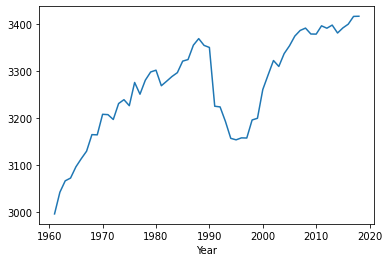

In [133]:
(
    fe_bulk.loc[("Total", "Europe"), "food_available_for_consumption__kcal_per_day"]
    / fe_bulk.loc[("Total", "Europe"), "population"]
).plot()

<AxesSubplot:xlabel='Year'>

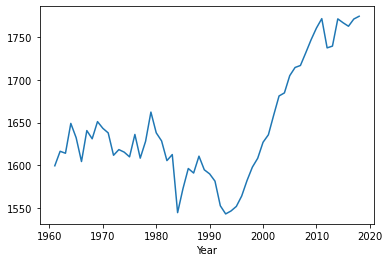

In [134]:
(
    fe_bulk.loc[
        ("Total", "Low-income countries"),
        "food_available_for_consumption__kcal_per_day",
    ]
    / fe_bulk.loc[("Total", "Low-income countries"), "population"]
).plot()

<AxesSubplot:xlabel='Year'>

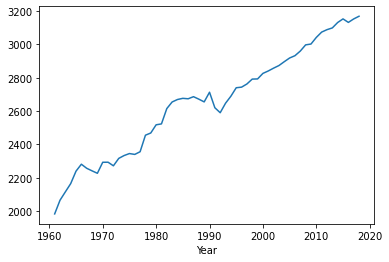

In [135]:
(
    fe_bulk.loc[
        ("Total", "Upper-middle-income countries"),
        "food_available_for_consumption__kcal_per_day",
    ]
    / fe_bulk.loc[("Total", "Upper-middle-income countries"), "population"]
).plot()